Iñigo Martin Melero

## Participante 1

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_1_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


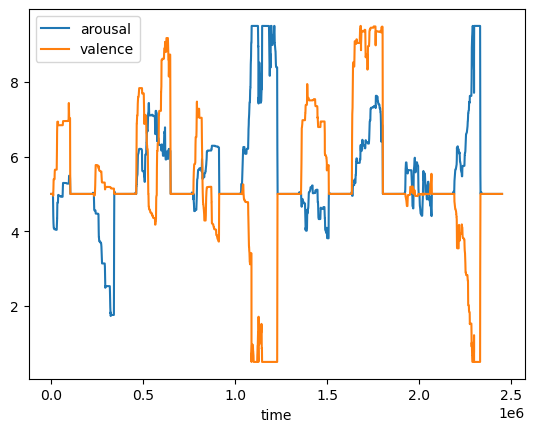

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_1_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.846  38.172  11.749  27.610  29.495     7.288     8.684   
1              1  0.836  38.249  11.737  27.601  29.488     7.288     8.725   
2              2  0.843  38.058  11.757  27.600  29.488     7.329     8.726   
3              3  0.836  38.075  11.730  27.572  29.481     7.207     8.644   
4              4  0.852  38.210  11.745  27.591  29.484     7.247     8.765   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  1.020  36.902   7.262  27.010  26.876     5.932     5.727   
2451580  2451580  1.014  36.990   7.259  27.020  26.876     5.892     5.727   
2451581  2451581  1.020  36.463   7.239  27.048  26.879     5.933     5.809   
2451582  2451582  1.023  36.602   7.227  27.030  26.883     5.974     5.769   
2451583  2451583  1.014  36.699   7.243  27.010  26.869     5.893     5.687   

         emg_trap  video  
0           6.550     10

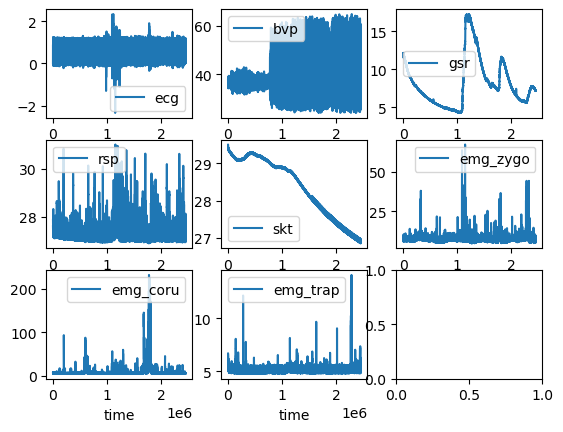

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

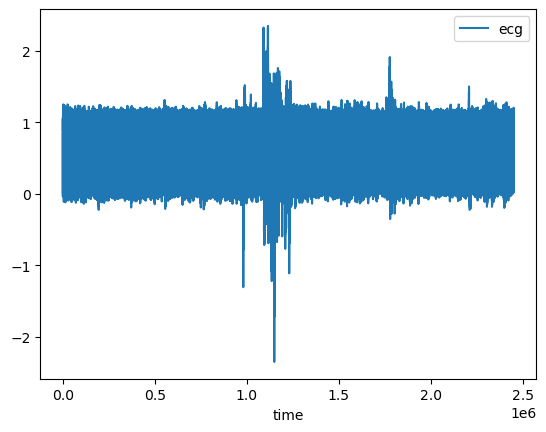

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

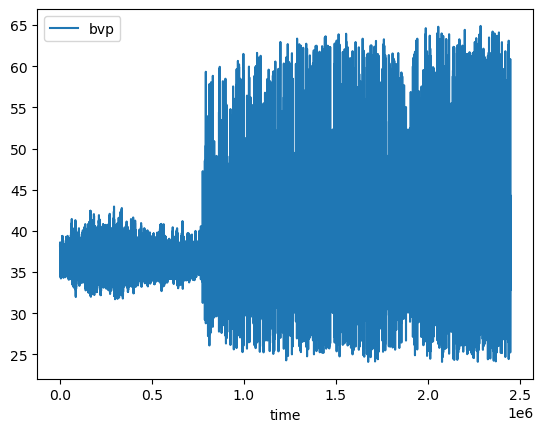

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

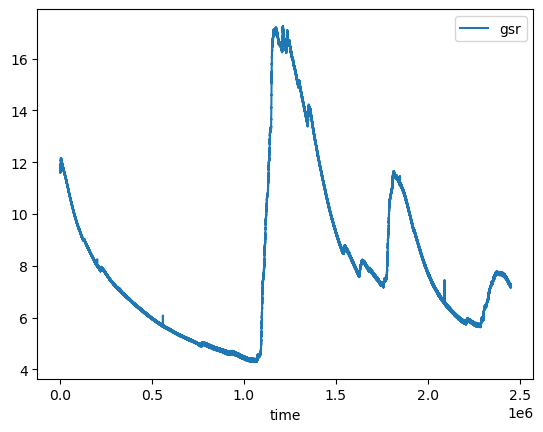

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

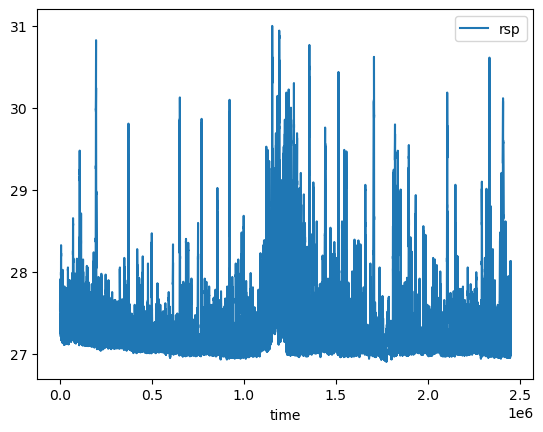

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

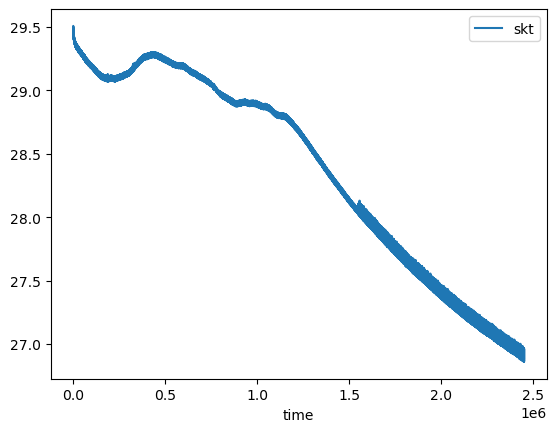

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

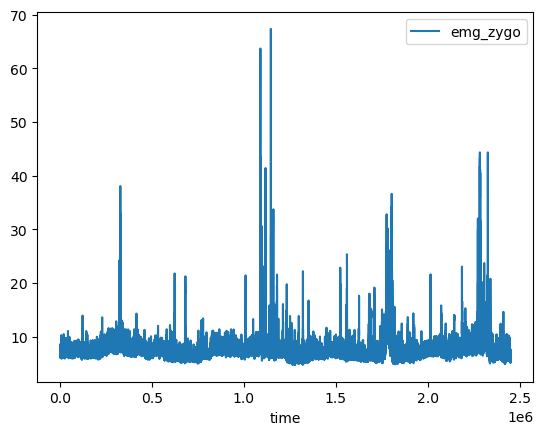

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

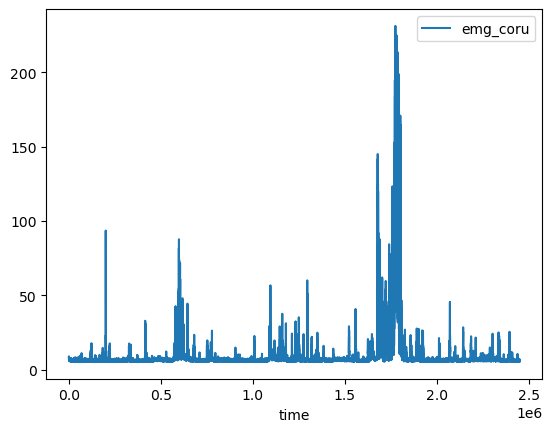

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

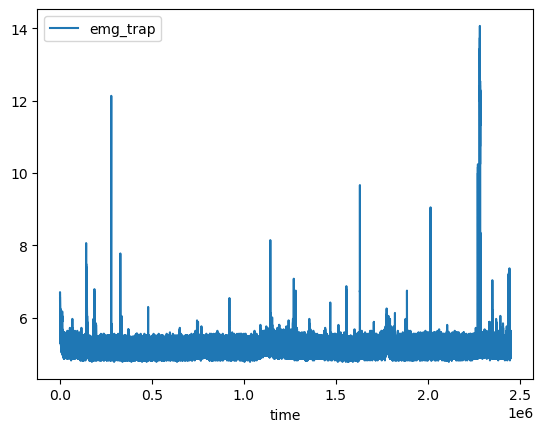

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

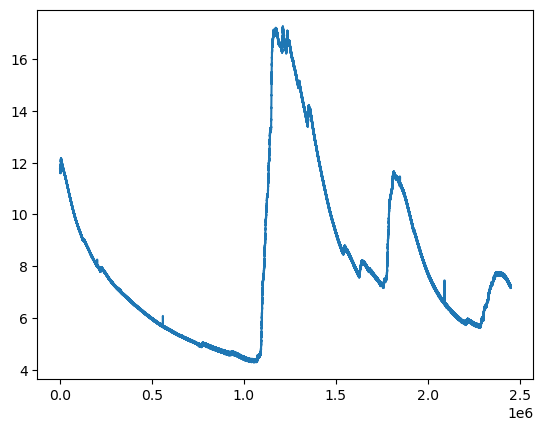

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

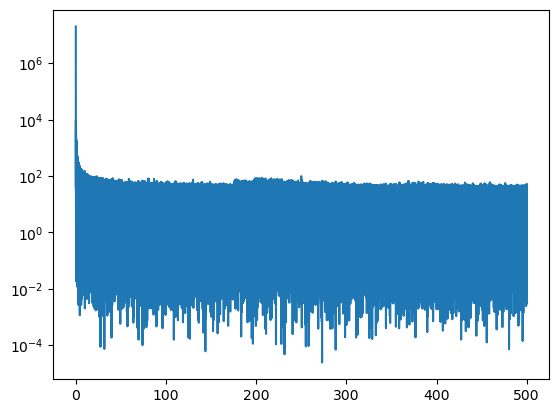

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

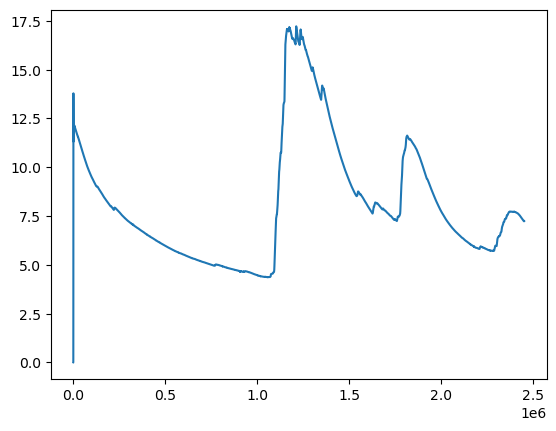

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0        0.000
1        0.000
2        0.000
3        0.000
4        0.000
...        ...
2451579  7.237
2451580  7.237
2451581  7.237
2451582  7.237
2451583  7.237

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

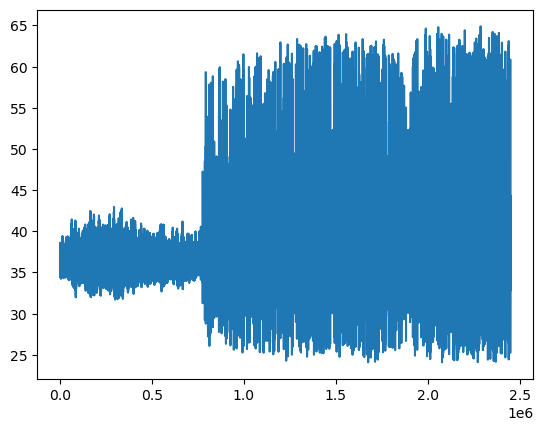

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

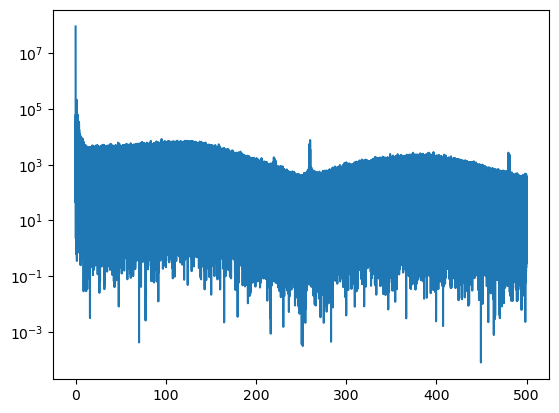

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

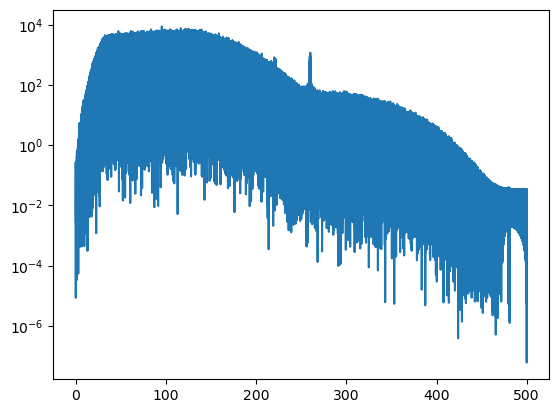

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.061
1        42.919
2        50.929
3        54.213
4        46.600
...         ...
2451579  37.689
2451580  38.015
2451581  37.771
2451582  37.338
2451583  37.029

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

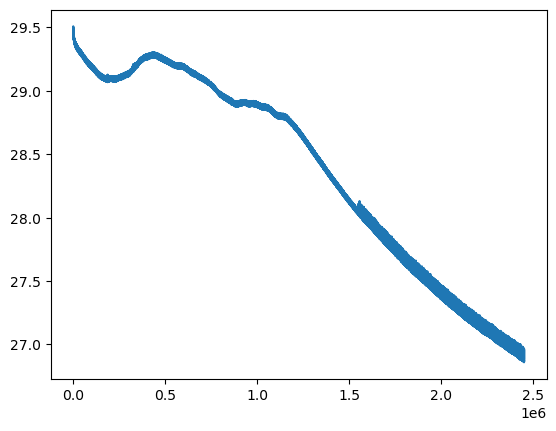

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

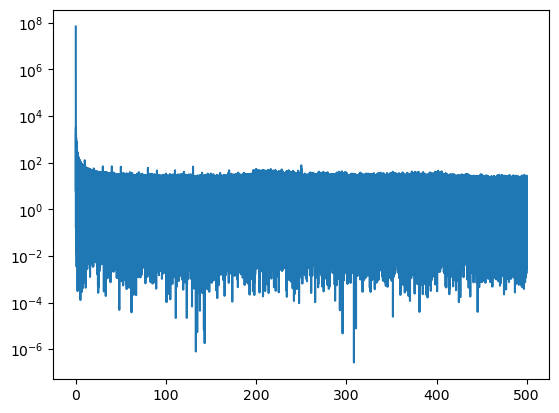

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

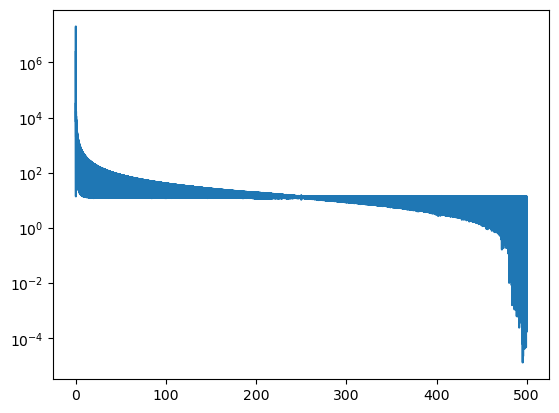

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

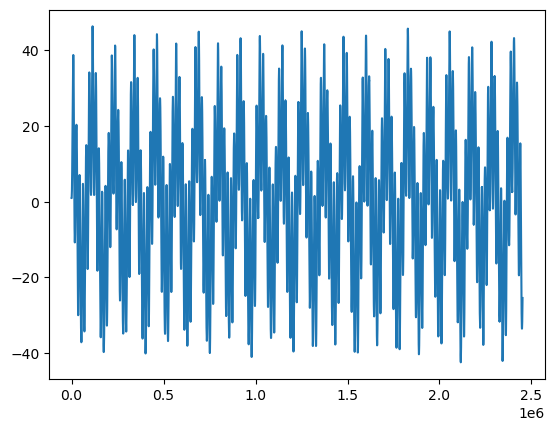

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.945
1        40.945
2        40.945
3        40.945
4        40.945
...         ...
2451579  14.514
2451580  14.519
2451581  14.524
2451582  14.528
2451583  14.533

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.846  27.610     7.288     8.684     6.550     10
1              1  0.836  27.601     7.288     8.725     6.468     10
2              2  0.843  27.600     7.329     8.726     6.589     10
3              3  0.836  27.572     7.207     8.644     6.468     10
4              4  0.852  27.591     7.247     8.765     6.507     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  1.020  27.010     5.932     5.727     5.194     12
2451580  2451580  1.014  27.020     5.892     5.727     5.112     12
2451581  2451581  1.020  27.048     5.933     5.809     5.274     12
2451582  2451582  1.023  27.030     5.974     5.769     5.316     12
2451583  2451583  1.014  27.010     5.893     5.687     5.154     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.846  27.610     7.288     8.684     6.550     10  38.061   
1              1  0.836  27.601     7.288     8.725     6.468     10  42.919   
2              2  0.843  27.600     7.329     8.726     6.589     10  50.929   
3              3  0.836  27.572     7.207     8.644     6.468     10  54.213   
4              4  0.852  27.591     7.247     8.765     6.507     10  46.600   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  1.020  27.010     5.932     5.727     5.194     12  37.689   
2451580  2451580  1.014  27.020     5.892     5.727     5.112     12  38.015   
2451581  2451581  1.020  27.048     5.933     5.809     5.274     12  37.771   
2451582  2451582  1.023  27.030     5.974     5.769     5.316     12  37.338   
2451583  2451583  1.014  27.010     5.893     5.687     5.154     12  37.029   

           gsr     skt  
0        0.000  40.945  
1        0.000  40.945  
2        0.000  40.945  
3        0.000  40.945  
4        0.000  40.945  
...        ...     ...  
2451579  7.237  14.514  
2451580  7.237  14.519  
2451581  7.237  14.524  
2451582  7.237  14.528  
2451583  7.237  14.533  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.665815  0.646568  0.269575  0.782399  0.047154  0.021782   
221502    221502  0.667944  0.646129  0.269575  0.782328  0.054239  0.022409   
221503    221503  0.666454  0.646845  0.269575  0.782246  0.049597  0.021766   
221504    221504  0.665815  0.648834  0.269575  0.782175  0.044955  0.020449   
221505    221505  0.663687  0.650683  0.269575  0.782092  0.040068  0.019790   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.711367  0.648048  0.200295  0.345532  0.032983  0.073217   
2331580  2331580  0.709877  0.648256  0.200295  0.345603  0.028341  0.069956   
2331581  2331581  0.709877  0.648325  0.200295  0.345685  0.028341  0.069266   
2331582  2331582  0.710515  0.647678  0.200295  0.345768  0.035182  0.070567   
2331583  2331583  0.707748  0.646244  0.200295  0.345851  0.035426  0.069924   

         emg_coru  emg_trap  video  
221501   0.008909  0.026619      3  
221502   0.009082  0.026404      3  
221503   0.008905  0.021985      3  
221504   0.008360  0.013148      3  
221505   0.007998  0.013040      3  
...           ...       ...    ...  
2331579  0.006170  0.065955      8  
2331580  0.005634  0.044294      8  
2331581  0.005630  0.048389      8  
2331582  0.005811  0.052807      8  
2331583  0.005630  0.044186      8  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.665815  0.646568  0.269575  0.047154  0.782399  0.021782   
221502    221502  0.667944  0.646129  0.269575  0.054239  0.782328  0.022409   
221503    221503  0.666454  0.646845  0.269575  0.049597  0.782246  0.021766   
221504    221504  0.665815  0.648834  0.269575  0.044955  0.782175  0.020449   
221505    221505  0.663687  0.650683  0.269575  0.040068  0.782092  0.019790   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.711367  0.648048  0.200295  0.032983  0.345532  0.073217   
2331580  2331580  0.709877  0.648256  0.200295  0.028341  0.345603  0.069956   
2331581  2331581  0.709877  0.648325  0.200295  0.028341  0.345685  0.069266   
2331582  2331582  0.710515  0.647678  0.200295  0.035182  0.345768  0.070567   
2331583  2331583  0.707748  0.646244  0.200295  0.035426  0.345851  0.069924   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.668582  0.649111  0.269652  0.047154  0.780946  0.027693  0.007630   
221540   0.685398  0.648371  0.269730  0.051796  0.779422  0.029011  0.007984   
221560   0.718391  0.648995  0.269886  0.042512  0.777887  0.026392  0.007635   
221580   0.508514  0.647631  0.269963  0.044955  0.776351  0.023758  0.007449   
221600   0.635802  0.648718  0.270041  0.044955  0.774815  0.028384  0.007449   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.699447  0.646984  0.200140  0.030540  0.338988  0.050777  0.005630   
2331520  0.700724  0.648371  0.200140  0.030540  0.340641  0.065973  0.005448   
2331540  0.700724  0.649342  0.200218  0.035426  0.342295  0.070615  0.004913   
2331560  0.707109  0.642198  0.200218  0.028341  0.343949  0.084446  0.005271   
2331580  0.709877  0.648256  0.200295  0.028341  0.345603  0.069956  0.005634   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.668582  0.649111  0.269652  0.047154  0.780946  0.027693  0.007630   
1      0.685398  0.648371  0.269730  0.051796  0.779422  0.029011  0.007984   
2      0.718391  0.648995  0.269886  0.042512  0.777887  0.026392  0.007635   
3      0.508514  0.647631  0.269963  0.044955  0.776351  0.023758  0.007449   
4      0.635802  0.648718  0.270041  0.044955  0.774815  0.028384  0.007449   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.699447  0.646984  0.200140  0.030540  0.338988  0.050777  0.005630   
63500  0.700724  0.648371  0.200140  0.030540  0.340641  0.065973  0.005448   
63501  0.700724  0.649342  0.200218  0.035426  0.342295  0.070615  0.004913   
63502  0.707109  0.642198  0.200218  0.028341  0.343949  0.084446  0.005271   
63503  0.709877  0.648256  0.200295  0.028341  0.345603  0.069956  0.005634   

       emg_trap  valence  arousal  
0      0.026404    5.000    5.000  
1      0.021877    5.000    5.000  
2      0.013040    5.000    5.000  
3      0.026404    5.000    5.000  
4      0.035241    5.000    5.000  
...         ...      ...      ...  
63499  0.065955    0.499    9.501  
63500  0.048604    0.499    9.501  
63501  0.044294    0.501    9.500  
63502  0.048604    0.502    9.499  
63503  0.044294    0.501    9.500  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.668582  0.649111  0.269652  0.047154  0.780946  0.027693  0.007630   
1      0.685398  0.648371  0.269730  0.051796  0.779422  0.029011  0.007984   
2      0.718391  0.648995  0.269886  0.042512  0.777887  0.026392  0.007635   
3      0.508514  0.647631  0.269963  0.044955  0.776351  0.023758  0.007449   
4      0.635802  0.648718  0.270041  0.044955  0.774815  0.028384  0.007449   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.677735  0.636210  0.199984  0.035182  0.332337  0.054054  0.010534   
63496  0.688165  0.644302  0.199984  0.030540  0.334003  0.085072  0.009989   
63497  0.691571  0.652070  0.200062  0.030540  0.335668  0.092365  0.008360   
63498  0.696679  0.651030  0.200062  0.028341  0.337322  0.063322  0.007263   
63499  0.699447  0.646984  0.200140  0.030540  0.338988  0.050777  0.005630   

       emg_trap  valence  arousal  
0      0.026404    5.000    5.000  
1      0.021877    5.000    5.000  
2      0.013040    5.000    5.000  
3      0.026404    5.000    5.000  
4      0.035241    5.000    5.000  
...         ...      ...      ...  
63495  0.070482    0.499    9.501  
63496  0.057334    0.500    9.500  
63497  0.066063    0.502    9.499  
63498  0.057226    0.500    9.500  
63499  0.065955    0.499    9.501  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.668582  0.649111  0.269652  0.047154  0.780946  0.027693  0.007630   
 1   0.685398  0.648371  0.269730  0.051796  0.779422  0.029011  0.007984   
 2   0.718391  0.648995  0.269886  0.042512  0.777887  0.026392  0.007635   
 3   0.508514  0.647631  0.269963  0.044955  0.776351  0.023758  0.007449   
 4   0.635802  0.648718  0.270041  0.044955  0.774815  0.028384  0.007449   
 5   0.686037  0.646776  0.270197  0.054239  0.773292  0.038231  0.008896   
 6   0.688804  0.647886  0.270274  0.047154  0.771744  0.063981  0.009449   
 7   0.690932  0.647400  0.270352  0.044710  0.770197  0.058696  0.013981   
 8   0.693699  0.648140  0.270508  0.047154  0.768649  0.056736  0.016354   
 9   0.693912  0.647354  0.270585  0.037870  0.767102  0.050777  0.016168   
 10  0.698808  0.649088  0.270741  0.047154  0.765554  0.048174  0.021988   
 11  0.702852  0.649042  0.270819  0.042512  0.764007  0.056720  0.023811   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.668582  0.649111  0.269652  0.047154  0.780946  0.027693  0.007630   
1     0.690932  0.646337  0.272218  0.047154  0.742177  0.067949  0.025258   
2     0.704342  0.648602  0.274007  0.044710  0.703160  0.028368  0.004364   
3     0.500213  0.648626  0.275017  0.044955  0.665241  0.041572  0.002186   
4     0.689655  0.648764  0.275717  0.042512  0.629532  0.038263  0.003271   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.693061  0.647077  0.187388  0.018813  0.154805  0.065989  0.005453   
2536  0.704342  0.647215  0.190265  0.040068  0.184844  0.061330  0.004169   
2537  0.690294  0.651307  0.193686  0.137063  0.219656  0.056720  0.003997   
2538  0.659642  0.625113  0.196330  0.163205  0.258177  0.076510  0.006174   
2539  0.695189  0.649643  0.198507  0.044710  0.299025  0.067274  0.006537   

             8         9        10  ...       193       194       195  \
0     0.026404  0.685398  0.648371  ...  0.689655  0.649874  0.272218   
1     0.030822  0.689655  0.648464  ...  0.704342  0.648533  0.273929   
2     0.035241  0.707109  0.649088  ...  0.710728  0.647770  0.275017   
3     0.048497  0.637718  0.646383  ...  0.679225  0.647654  0.275640   
4     0.021985  0.708387  0.650013  ...  0.676245  0.647215  0.276495   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.022201  0.697318  0.647077  ...  0.704342  0.647886  0.190187   
2536  0.043862  0.701575  0.653088  ...  0.692422  0.646105  0.193609   
2537  0.039767  0.693699  0.647146  ...  0.663048  0.651654  0.196330   
2538  0.039659  0.662410  0.642984  ...  0.694551  0.646568  0.198429   
2539  0.043970  0.694551  0.649088  ...  0.699447  0.646984  0.200140   

           196       197       198       199       200  valence  arousal  
0     0.044955  0.743736  0.077201  0.022351  0.030822  5.00000  5.00000  
1     0.044955  0.704719  0.029043  0.005090  0.044078  5.00000  5.00000  
2     0.047154  0.666730  0.036271  0.001996  0.021877  5.00000  5.00000  
3     0.047154  0.630902  0.038279  0.003634  0.030822  5.00000  5.00000  
4     0.075495  0.598157  0.025059  0.001815  0.048389  5.00000  5.00000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.042267  0.183545  0.067274  0.004355  0.048281  0.50000  9.50000  
2536  0.134620  0.218180  0.040914  0.004178  0.048497  0.50008  9.50000  
2537  0.172490  0.256583  0.048174  0.005634  0.044078  0.50000  9.49988  
2538  0.047154  0.297360  0.058037  0.007626  0.039552  0.49980  9.50008  
2539  0.030540  0.338988  0.050777  0.005630  0.065955  0.49984  9.50020  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.668582  0.649111  0.269652  0.047154  0.780946  0.027693  0.007630   
1     0.690932  0.646337  0.272218  0.047154  0.742177  0.067949  0.025258   
2     0.704342  0.648602  0.274007  0.044710  0.703160  0.028368  0.004364   
3     0.500213  0.648626  0.275017  0.044955  0.665241  0.041572  0.002186   
4     0.689655  0.648764  0.275717  0.042512  0.629532  0.038263  0.003271   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.693061  0.647077  0.187388  0.018813  0.154805  0.065989  0.005453   
2536  0.704342  0.647215  0.190265  0.040068  0.184844  0.061330  0.004169   
2537  0.690294  0.651307  0.193686  0.137063  0.219656  0.056720  0.003997   
2538  0.659642  0.625113  0.196330  0.163205  0.258177  0.076510  0.006174   
2539  0.695189  0.649643  0.198507  0.044710  0.299025  0.067274  0.006537   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub1.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.668582  0.649111  0.269652  0.047154  0.780946  0.027693  0.007630   
1     0.690932  0.646337  0.272218  0.047154  0.742177  0.067949  0.025258   
2     0.704342  0.648602  0.274007  0.044710  0.703160  0.028368  0.004364   
3     0.500213  0.648626  0.275017  0.044955  0.665241  0.041572  0.002186   
4     0.689655  0.648764  0.275717  0.042512  0.629532  0.038263  0.003271   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.693061  0.647077  0.187388  0.018813  0.154805  0.065989  0.005453   
2536  0.704342  0.647215  0.190265  0.040068  0.184844  0.061330  0.004169   
2537  0.690294  0.651307  0.193686  0.137063  0.219656  0.056720  0.003997   
2538  0.659642  0.625113  0.196330  0.163205  0.258177  0.076510  0.006174   
2539  0.695189  0.649643  0.198507  0.044710  0.299025  0.067274  0.006537   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub1.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.668582  0.649111  0.269652  0.047154  0.780946  0.027693  0.007630   
1     0.690932  0.646337  0.272218  0.047154  0.742177  0.067949  0.025258   
2     0.704342  0.648602  0.274007  0.044710  0.703160  0.028368  0.004364   
3     0.500213  0.648626  0.275017  0.044955  0.665241  0.041572  0.002186   
4     0.689655  0.648764  0.275717  0.042512  0.629532  0.038263  0.003271   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.693061  0.647077  0.187388  0.018813  0.154805  0.065989  0.005453   
2536  0.704342  0.647215  0.190265  0.040068  0.184844  0.061330  0.004169   
2537  0.690294  0.651307  0.193686  0.137063  0.219656  0.056720  0.003997   
2538  0.659642  0.625113  0.196330  0.163205  0.258177  0.076510  0.006174   
2539  0.695189  0.649643  0.198507  0.044710  0.299025  0.067274  0.006537   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub1.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.668582  0.649111  0.269652  0.047154  0.780946  0.027693  0.007630   
1     0.690932  0.646337  0.272218  0.047154  0.742177  0.067949  0.025258   
2     0.704342  0.648602  0.274007  0.044710  0.703160  0.028368  0.004364   
3     0.500213  0.648626  0.275017  0.044955  0.665241  0.041572  0.002186   
4     0.689655  0.648764  0.275717  0.042512  0.629532  0.038263  0.003271   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.693061  0.647077  0.187388  0.018813  0.154805  0.065989  0.005453   
2536  0.704342  0.647215  0.190265  0.040068  0.184844  0.061330  0.004169   
2537  0.690294  0.651307  0.193686  0.137063  0.219656  0.056720  0.003997   
2538  0.659642  0.625113  0.196330  0.163205  0.258177  0.076510  0.006174   
2539  0.695189  0.649643  0.198507  0.044710  0.299025  0.067274  0.006537   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub1.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.668582  0.649111  0.269652  0.047154  0.780946  0.027693  0.007630   
1     0.690932  0.646337  0.272218  0.047154  0.742177  0.067949  0.025258   
2     0.704342  0.648602  0.274007  0.044710  0.703160  0.028368  0.004364   
3     0.500213  0.648626  0.275017  0.044955  0.665241  0.041572  0.002186   
4     0.689655  0.648764  0.275717  0.042512  0.629532  0.038263  0.003271   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.693061  0.647077  0.187388  0.018813  0.154805  0.065989  0.005453   
2536  0.704342  0.647215  0.190265  0.040068  0.184844  0.061330  0.004169   
2537  0.690294  0.651307  0.193686  0.137063  0.219656  0.056720  0.003997   
2538  0.659642  0.625113  0.196330  0.163205  0.258177  0.076510  0.006174   
2539  0.695189  0.649643  0.198507  0.044710  0.299025  0.067274  0.006537   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub1.csv', index=False)